In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['encore un petit effort', 'we re almost there']


In [9]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded)
        return output, (hidden, cell)

class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden  # Initialize decoder's initial hidden state with encoder's last hidden state
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # Detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        return output, hidden

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [11]:
from sklearn.model_selection import train_test_split

def get_data(batch_size = 32 , test_size=0.2):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
    first_pairs, test_pairs = train_test_split(pairs, test_size=test_size, random_state=42)
    train_pairs, valid_pairs = train_test_split(first_pairs, test_size=test_size, random_state=42)

    def prepare_dataset(pairs):
        n = len(pairs)
        input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
        target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

        for idx, (inp, tgt) in enumerate(pairs):
            inp_ids = indexesFromSentence(input_lang, inp)
            tgt_ids = indexesFromSentence(output_lang, tgt)
            inp_ids.append(EOS_token)
            tgt_ids.append(EOS_token)
            input_ids[idx, :len(inp_ids)] = inp_ids
            target_ids[idx, :len(tgt_ids)] = tgt_ids

        return TensorDataset(torch.LongTensor(input_ids).to(device),
                             torch.LongTensor(target_ids).to(device))

    train_data = prepare_dataset(train_pairs)
    test_data = prepare_dataset(test_pairs)
    valid_data = prepare_dataset(valid_pairs)

    # Creation of DataLoaders
    train_sampler = RandomSampler(train_data)
    valid_sampler = RandomSampler(valid_data)
    test_sampler = SequentialSampler(test_data)
    
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    
    return input_lang, output_lang, pairs, train_dataloader, valid_dataloader, test_dataloader

In [12]:
def sentenceFromTensor(lang, tensor):
    words = [lang.index2word[idx.item()] for idx in tensor if idx.item() not in (SOS_token, EOS_token)]
    return ' '.join(words)

def evaluate_bleu(dataloader, encoder, decoder, input_lang, output_lang):
    references = []
    candidates = []
    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

            for i in range(input_tensor.size(0)):
                candidate = sentenceFromTensor(output_lang, torch.argmax(decoder_outputs[i], dim=1))
                reference = sentenceFromTensor(output_lang, target_tensor[i])
                candidates.append(candidate.split())
                references.append([reference.split()])

    return corpus_bleu(references, candidates, smoothing_function=SmoothingFunction().method4)

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate_test(dataloader, encoder, decoder, criterion):
    with torch.no_grad():
        total_loss = 0
        for data in dataloader:
            input_tensor, target_tensor = data
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
            total_loss += loss.item()
        return total_loss / len(dataloader)


In [13]:
def train(train_dataloader,valid_dataloader, test_dataloader, encoder, decoder, n_epochs, input_lang, output_lang, learning_rate=0.001, print_every=1):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    train_losses = []
    test_losses = []
    valid_losses = []
    train_bleu_scores = []
    test_bleu_scores = []
    valid_bleu_scores = []

    start = time.time()

    for epoch in range(1, n_epochs + 1):
        encoder.train()
        decoder.train()
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        train_losses.append(train_loss)

        encoder.eval()
        decoder.eval()
        valid_loss = evaluate_test(valid_dataloader, encoder, decoder, criterion)
        valid_losses.append(valid_loss)
        test_loss = evaluate_test(test_dataloader, encoder, decoder, criterion)
        test_losses.append(test_loss)

        train_bleu_score = evaluate_bleu(train_dataloader, encoder, decoder, input_lang, output_lang)
        valid_bleu_score = evaluate_bleu(valid_dataloader, encoder, decoder, input_lang, output_lang)
        test_bleu_score = evaluate_bleu(test_dataloader, encoder, decoder, input_lang, output_lang)
        train_bleu_scores.append(train_bleu_score)
        valid_bleu_scores.append(valid_bleu_score)
        test_bleu_scores.append(test_bleu_score)
        print(f'========== epoch : {epoch} ========== ')
        print(f'\nTrain Loss: {train_loss:.4f},Valid Loss : {valid_loss:.4f}, Test Loss: {test_loss:.4f}')
        print(f'\nTrain BLEU: {train_bleu_score:.4f}, Valid BLEU: {valid_bleu_score:.4f},Test BLEU: {test_bleu_score:.4f}')

        if epoch % print_every == 0:
            print(f'Epoch {epoch} ===============  Train Loss: {train_loss:.4f},Valid Loss : {valid_loss:.4f}, Test Loss: {test_loss:.4f}, Train BLEU: {train_bleu_score:.4f}, Test BLEU: {test_bleu_score:.4f}')
            print(f'{timeSince(start, epoch / n_epochs)} ({epoch} {epoch / n_epochs * 100:.0f}%)')

    return train_losses, valid_losses, test_losses, train_bleu_scores, valid_bleu_scores, test_bleu_scores

# Example usage:
# encoder = EncoderRNN(input_size, hidden_size).to(device)
# decoder = DecoderRNN(hidden_size, output_size).to(device)
# train_losses, test_losses, train_bleu_scores, test_bleu_scores = train(train_dataloader, test_dataloader, encoder, decoder, n_epochs, input_lang, output_lang)


In [15]:
input_lang, output_lang, pairs, train_dataloader, valid_dataloader, test_dataloader = get_data()

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


In [16]:
%%time
hidden_size = 128
batch_size = 32


encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_lang.n_words).to(device)

train_losses, valid_losses, test_losses, train_bleu_scores, valid_bleu_scores, test_bleu_scores = train(train_dataloader, valid_dataloader, test_dataloader, encoder, decoder, 80, input_lang, output_lang, learning_rate=0.001, print_every=100)

========== epoch : 1 ========== 

Train Loss: 2.9570,Valid Loss : 2.2934, Test Loss: 2.2061

Train BLEU: 0.0195, Valid BLEU: 0.0264,Test BLEU: 0.0252
========== epoch : 2 ========== 

Train Loss: 2.0554,Valid Loss : 2.0275, Test Loss: 1.9397

Train BLEU: 0.0568, Valid BLEU: 0.0502,Test BLEU: 0.0598
========== epoch : 3 ========== 

Train Loss: 1.8301,Valid Loss : 1.8724, Test Loss: 1.7833

Train BLEU: 0.1154, Valid BLEU: 0.1086,Test BLEU: 0.1087
========== epoch : 4 ========== 

Train Loss: 1.6654,Valid Loss : 1.7570, Test Loss: 1.6665

Train BLEU: 0.1392, Valid BLEU: 0.1287,Test BLEU: 0.1377
========== epoch : 5 ========== 

Train Loss: 1.5320,Valid Loss : 1.6582, Test Loss: 1.5737

Train BLEU: 0.1539, Valid BLEU: 0.1363,Test BLEU: 0.1462
========== epoch : 6 ========== 

Train Loss: 1.4191,Valid Loss : 1.5913, Test Loss: 1.5035

Train BLEU: 0.1689, Valid BLEU: 0.1489,Test BLEU: 0.1588
========== epoch : 7 ========== 

Train Loss: 1.3185,Valid Loss : 1.5292, Test Loss: 1.4447

Train B

========== epoch : 56 ========== 

Train Loss: 0.0485,Valid Loss : 1.3942, Test Loss: 1.2758

Train BLEU: 0.9575, Valid BLEU: 0.4396,Test BLEU: 0.4555
========== epoch : 57 ========== 

Train Loss: 0.0444,Valid Loss : 1.3970, Test Loss: 1.2879

Train BLEU: 0.9584, Valid BLEU: 0.4343,Test BLEU: 0.4488
========== epoch : 58 ========== 

Train Loss: 0.0438,Valid Loss : 1.4013, Test Loss: 1.2920

Train BLEU: 0.9568, Valid BLEU: 0.4292,Test BLEU: 0.4555
========== epoch : 59 ========== 

Train Loss: 0.0441,Valid Loss : 1.4150, Test Loss: 1.2961

Train BLEU: 0.9592, Valid BLEU: 0.4369,Test BLEU: 0.4498
========== epoch : 60 ========== 

Train Loss: 0.0401,Valid Loss : 1.4421, Test Loss: 1.3083

Train BLEU: 0.9597, Valid BLEU: 0.4423,Test BLEU: 0.4551
========== epoch : 61 ========== 

Train Loss: 0.0378,Valid Loss : 1.4452, Test Loss: 1.3212

Train BLEU: 0.9592, Valid BLEU: 0.4363,Test BLEU: 0.4550
========== epoch : 62 ========== 

Train Loss: 0.0374,Valid Loss : 1.4485, Test Loss: 1.3284



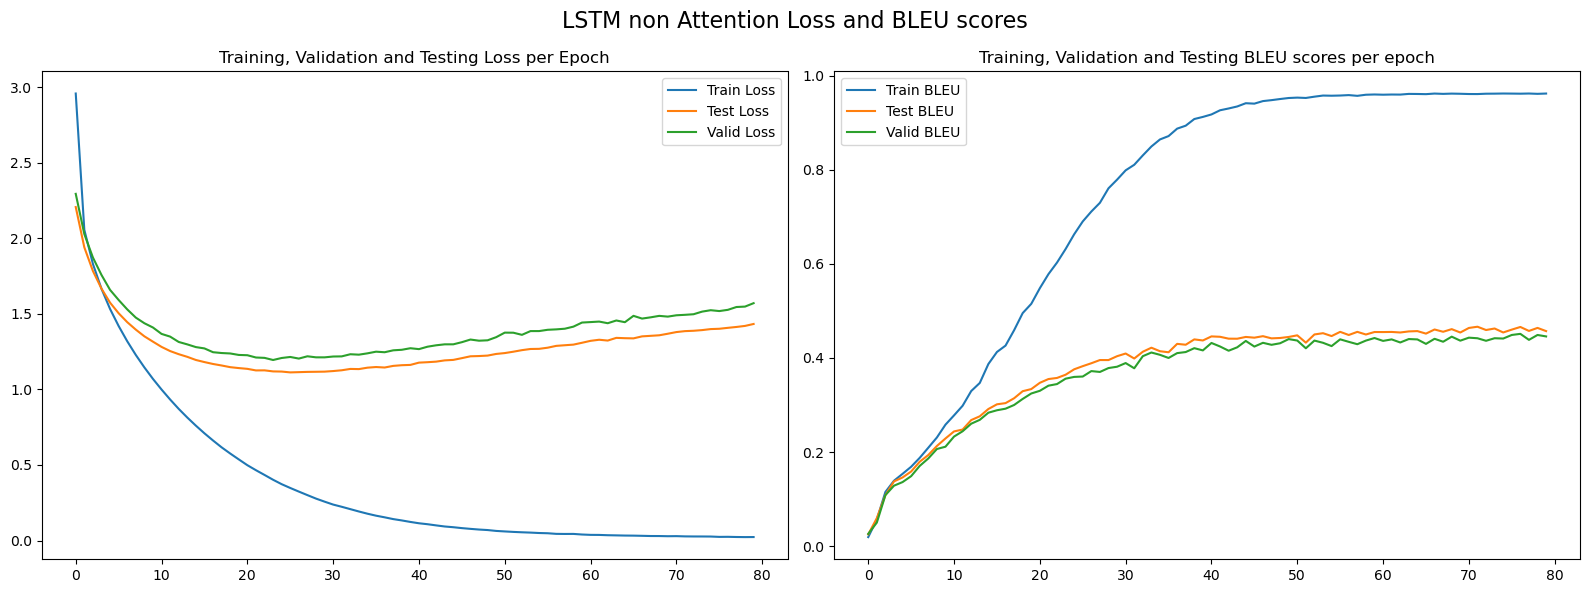

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Sous-graphe 1 : Losses
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].plot(valid_losses, label='Valid Loss')
axs[0].set_title('Training, Validation and Testing Loss per Epoch')
axs[0].legend()

# Sous-graphe 2 : BLEU scores
axs[1].plot(train_bleu_scores, label='Train BLEU')
axs[1].plot(test_bleu_scores, label='Test BLEU')
axs[1].plot(valid_bleu_scores, label='Valid BLEU')
axs[1].set_title('Training, Validation and Testing BLEU scores per epoch')
axs[1].legend()

fig.suptitle('LSTM non Attention Loss and BLEU scores', fontsize=16)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig('LSTM non Attention Loss and BLEU scores.png', dpi=300)

# Ajuster les sous-graphiques
fig.tight_layout()
plt.show()

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.lstm = nn.LSTM(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        # LSTM hidden state: (h, c)
        query = hidden[0].permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)

        output, hidden = self.lstm(input_lstm, hidden)
        output = self.out(output)

        return output, hidden, attn_weights
